### Link to PatchForensic Project ###

Summary: https://chail.github.io/patch-forensics/

Full paper: https://arxiv.org/pdf/2008.10588.pdf

Code: https://github.com/chail/patch-forensics

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load in data ###

In [2]:
valid_size = .2
batch_size = 16
num_workers = 2
classes = ["Real", "Fake"]

train_transform = transforms.Compose([transforms.RandomResizedCrop(229),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

test_transform = transforms.Compose([transforms.CenterCrop(229),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

#train_transform = transforms.Compose([transforms.RandomResizedCrop(229)])

#test_transform = transforms.Compose([transforms.CenterCrop(229)])

train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)
test_dataset = datasets.ImageFolder("./CNN_synth_testset/progan/horse/", transform=test_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

class_names = train_dataset.classes


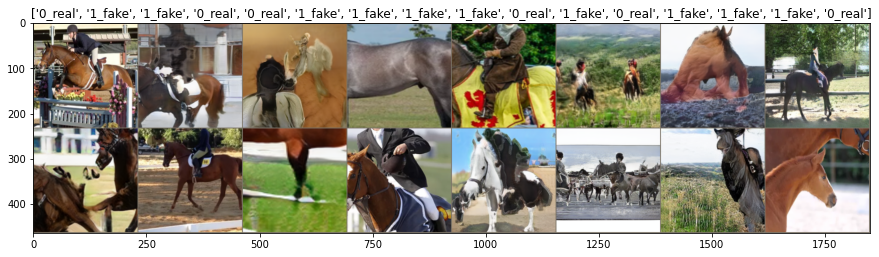

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Xception first blocks implementation: Entry flow block ###

https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

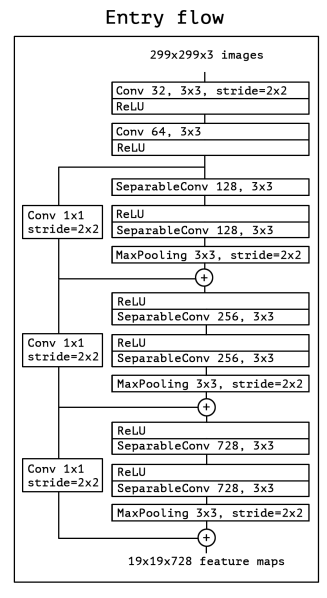

In [4]:
class SeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False):
        super(SeparableConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups = in_channels, bias = bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x) 
        return x
    
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, repeatTime, relu = True):
        super(Block, self).__init__()
        self.relu = nn.ReLU(inplace = True)

        if in_channels != out_channels or stride != 1:
            self.skipLayer = nn.Conv2d(in_channels, out_channels, 1, stride, bias = False)
            self.skipBatchNorm = nn.BatchNorm2d(out_channels)
        else:
            self.skipLayer = None

        sequential = []
        channels = in_channels

        sequential.append(self.relu)
        sequential.append(SeparableConv(in_channels, out_channels, 3, stride = 1, padding = 1, bias = False))
        sequential.append(nn.BatchNorm2d(out_channels))
        channels = out_channels

        for timeLeft in range(0, repeatTime - 1):
            sequential.append(self.relu)
            sequential.append(SeparableConv(channels, channels, 3, stride = 1, padding = 1, bias = False))
            sequential.append(nn.BatchNorm2d(channels))

        if relu == False:
            sequential = sequential[1:]
        else:
            sequential[0] = nn.ReLU(inplace = True)

        if stride != 1:
            sequential.append(nn.MaxPool2d(3, stride, 1))

        self.sequential = nn.Sequential(*sequential)
    def forward(self, x):
        main = self.sequential(x)
        if self.skipLayer is not None:
            skipLayer = self.skipLayer(x)
            skipLayer = self.skipBatchNorm(skipLayer)
        else:
            skipLayer = x
        
        main += skipLayer
        return main

In [5]:
class Xception_entry_flow(nn.Module):
    def __init__(self):
        super(Xception_entry_flow, self).__init__()
        ####################  
        self.conv1_1 = nn.Conv2d(3, 32, 3, 2, padding = 0, bias = False)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace = True)
        
        self.conv1_2 = nn.Conv2d(32, 64, 3, padding = 0, bias = False)
        self.bn1_2 = nn.BatchNorm2d(64)
        #ReLU here
        #####################
        self.block1 = Block(64, 128, 2, 2, relu = False)
        #######################
        self.block2 = Block(128, 256, 2, 2, relu = True)
        ########################
        self.block3 = Block(256, 728, 2, 2, relu = True)
        #########################
        self.fc1 = nn.Linear(14*14*728, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        #print('input shape', x.shape)
        x = self.conv1_1(x)
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(-1, 14*14*728) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [13]:
model = Xception_entry_flow()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = .9)
criterion = nn.CrossEntropyLoss()
num_epochs = 3
since = time.time()
print_every_n_batches = 200
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    #running_corrects = 0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        #outputs = torch.argmax(outputs, 1)
        #print('output', outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #running_corrects += torch.sum(preds == labels.data)
        
        if i % print_every_n_batches == print_every_n_batches - 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches), end = " ")
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
    
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #optimizer.param_groups[0]['lr'] -= 1e-4
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 1/3
----------
[1,   200] loss: 0.717 Time elapsed: 0m 8s
[1,   400] loss: 0.695 Time elapsed: 0m 16s
[1,   600] loss: 0.694 Time elapsed: 0m 24s
[1,   800] loss: 0.694 Time elapsed: 0m 32s
[1,  1000] loss: 0.694 Time elapsed: 0m 40s
[1,  1200] loss: 0.692 Time elapsed: 0m 48s
[1,  1400] loss: 0.694 Time elapsed: 0m 56s
[1,  1600] loss: 0.692 Time elapsed: 1m 4s
[1,  1800] loss: 0.694 Time elapsed: 1m 12s
Epoch 2/3
----------
[2,   200] loss: 0.693 Time elapsed: 1m 20s
[2,   400] loss: 0.693 Time elapsed: 1m 28s
[2,   600] loss: 0.694 Time elapsed: 1m 36s
[2,   800] loss: 0.693 Time elapsed: 1m 44s
[2,  1000] loss: 0.693 Time elapsed: 1m 52s
[2,  1200] loss: 0.690 Time elapsed: 2m 0s
[2,  1400] loss: 0.692 Time elapsed: 2m 8s
[2,  1600] loss: 0.693 Time elapsed: 2m 16s
[2,  1800] loss: 0.691 Time elapsed: 2m 24s
Epoch 3/3
----------
[3,   200] loss: 0.691 Time elapsed: 2m 32s
[3,   400] loss: 0.690 Time elapsed: 2m 40s
[3,   600] loss: 0.693 Time elapsed: 2m 48s
[3,   800] loss: 

In [14]:
n = 0
acc = torch.tensor(0).to(device)
for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_pred = torch.argmax(model.forward(inputs), 1) 
    acc = torch.add(acc, torch.sum(y_pred == labels))
    n += len(labels)
    
acc / float(n)

tensor(0.5175, device='cuda:0')

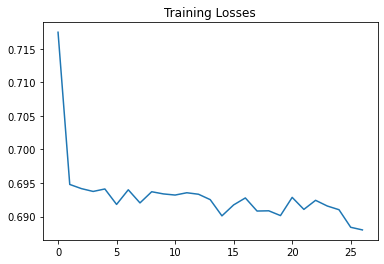

In [15]:
plt.title("Training Losses")
plt.plot(losses)

### RESNET18 Nick ###

In [7]:
# resnet = models.resnet18(pretrained=True)

# model = nn.Sequential(resnet, nn.Linear(1000, 2))
# model = model.to(device)

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = .9)
# criterion = nn.CrossEntropyLoss()

In [8]:
# num_epochs = 3
# since = time.time()
# print_every_n_batches = 200
# losses = []
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     #running_corrects = 0
    
#     print(f'Epoch {epoch + 1}/{num_epochs}')
#     print('-' * 10)
#     for i, data in enumerate(train_loader):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         #_, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         #running_corrects += torch.sum(preds == labels.data)
        
#         if i % print_every_n_batches == print_every_n_batches - 1:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every_n_batches), end = " ")
#             losses.append(running_loss / print_every_n_batches)
#             running_loss = 0.0
            
    
#             time_elapsed = time.time() - since
#             print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     optimizer.param_groups[0]['lr'] -= 1e-4
        
# time_elapsed = time.time() - since
# print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

In [9]:
# n = 0
# acc = torch.tensor(0).to(device)
# for data in test_loader:
#     inputs, labels = data
#     inputs, labels = inputs.to(device), labels.to(device)
#     y_pred = torch.argmax(model.forward(inputs), 1) 
#     acc = torch.add(acc, torch.sum(y_pred == labels))
#     n += len(labels)
    
# acc / float(n)

In [10]:
# plt.title("Training Losses")
# plt.plot(losses)